In [44]:
import torchmetrics
import sys
import numpy as np
sys.path.append('C:/Users/kupec/OneDrive/Desktop/neuroforest-main/neuroforest-master')
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from neuroforest.dataset import image_loader
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"




In [52]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(24 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 1)  # Assuming 10 classes for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 24 * 32 * 32)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = 53*F.sigmoid(x)
        return x

with_mushroom_no_timestamp


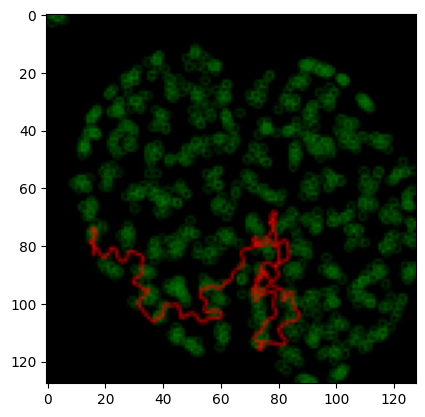

(128, 128, 3)

In [3]:
image, label = image_loader[3]
print(image_loader.get_category(3))
image = image.permute(1, 2, 0).numpy() 
plt.imshow(image)

plt.show()
image.shape


In [ ]:
def create_train_test_split(image_loader, test_size: float = 0.2):
    # Calculer la taille des ensembles de test et d'entraînement
    dataset_size = len(image_loader)
    test_size = int(test_size * dataset_size)
    train_size = dataset_size - test_size
    
    # Diviser le dataset en ensembles de test et d'entraînement
    train_dataset, test_dataset = random_split(image_loader, [train_size, test_size])
    
    return train_dataset, test_dataset



In [48]:
def create_dataloader(image_loader, batch_size: int, category: str) -> DataLoader:
    filtered_indices = image_loader.get_indices_by_category(category)
    
    # Créer un sous-dataset avec les indices filtrés
    filtered_dataset = Subset(image_loader, filtered_indices)

    # Retourner un DataLoader avec les données filtrées
    return DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

dataloader_with_mushroom_with_timestamp = create_dataloader(
    image_loader, 5, "with_mushroom_with_timestamp"
)




In [49]:
def calculate_score(labels):
    score_keys = ['asrs1', 'asrs2', 'asrs3', 'asrs4', 'asrs5', 'asrs6', 'asrs7', 'asrs8', 'asrs9', 'asrs10', 'asrs11', 'asrs12', 'asrs13', 'asrs14', 'asrs15', 'asrs16', 'asrs17', 'asrs18']
    score_final = []
    for i in range(int(len(labels["Name"]))):
        score = sum(int(labels[key][i]) for key in score_keys)
        score_final.append(score)
    return score_final

for batch in dataloader_with_mushroom_with_timestamp:
    images, labels = batch
    print(calculate_score(labels))
    break


[33, 20, 37, 23, 36]


In [53]:
dataloader = dataloader_with_mushroom_with_timestamp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
for batch, label in dataloader:
    label = torch.tensor(calculate_score(label)).float()
    batch, label = batch.to(device), label.to(device)
    output = model(batch)
    print(output)
    print(label)
    print(F.mse_loss(output, label))
    break

tensor([[23.5887],
        [23.5824],
        [23.6005],
        [23.5742],
        [23.5478]], grad_fn=<MulBackward0>)
tensor([26., 24., 31., 10., 33.])
tensor(66.8519, grad_fn=<MseLossBackward0>)


C:\Users\kupec\AppData\Local\Temp\ipykernel_17372\2956642576.py:10: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(output, label))


Epoch 1, Loss: 127.16640543937683
Epoch 2, Loss: 108.58770442008972
Epoch 3, Loss: 140.8295742869377
Epoch 4, Loss: 117.17430818080902
Epoch 5, Loss: 114.87786722183228
Epoch 6, Loss: 124.62026989459991
Epoch 7, Loss: 106.53208708763123
Epoch 8, Loss: 107.07478880882263
Epoch 9, Loss: 104.82209801673889
Epoch 10, Loss: 105.3055409193039
Epoch 11, Loss: 105.28925156593323
Epoch 12, Loss: 112.19222176074982
Epoch 13, Loss: 102.13152192346752
Epoch 14, Loss: 105.80474352836609
Epoch 15, Loss: 101.8331712782383
Epoch 16, Loss: 106.54397088289261
Epoch 17, Loss: 106.69129419326782
Epoch 18, Loss: 101.90115493535995
Epoch 19, Loss: 100.96722033512924
Epoch 20, Loss: 135.3274085521698
Epoch 21, Loss: 116.59938514232635
Epoch 22, Loss: 102.99643690139055
Epoch 23, Loss: 106.0134807229042
Epoch 24, Loss: 105.78756642341614
Epoch 25, Loss: 107.92743694782257


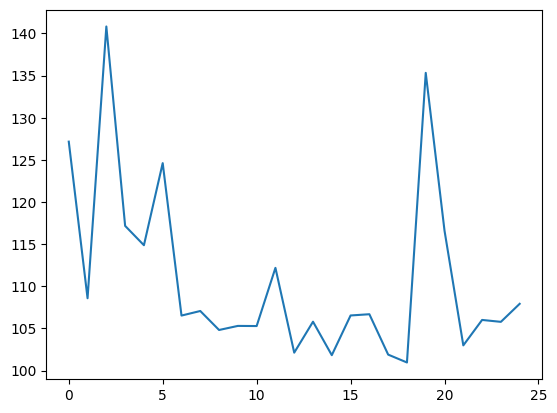

In [54]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25
training_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        labels = torch.tensor(calculate_score(labels)).float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_loss.append(running_loss/len(dataloader))

    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader_with_mushroom_with_timestamp)}")
    
plt.plot(training_loss)